# Timeseries

Ce notebook présente quelques étapes simples pour une série temporelle. La plupart utilise le module [statsmodels.tsa](https://www.statsmodels.org/stable/tsa.html#module-statsmodels.tsa).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Données

Les données sont artificielles mais simulent ce que pourraient être le chiffre d'affaires d'un magasin de quartier, des samedi très forts, une semaine morne, un Noël chargé, un été plat.

In [3]:
from ensae_teaching_cs.data import generate_sells
import pandas
df = pandas.DataFrame(generate_sells())
df.head()

,date,value
0,2017-07-11 00:42:57.463554,0.004343
1,2017-07-12 00:42:57.463554,0.003907
2,2017-07-13 00:42:57.463554,0.005510
3,2017-07-14 00:42:57.463554,0.007843
4,2017-07-15 00:42:57.463554,0.009586


## Premiers graphiques

La série a deux saisonnalités, hebdomadaire, mensuelle.

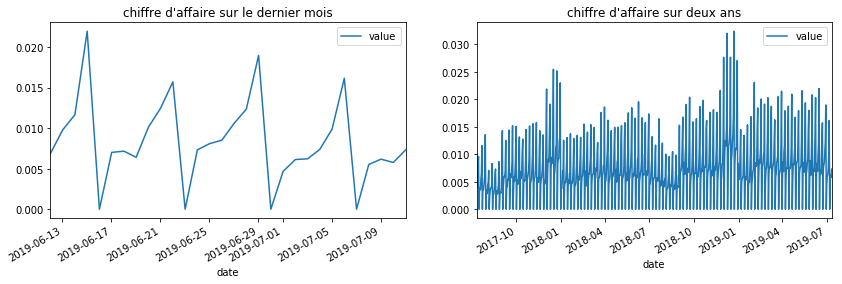

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
df.iloc[-30:].set_index('date').plot(ax=ax[0])
df.set_index('date').plot(ax=ax[1])
ax[0].set_title("chiffre d'affaire sur le dernier mois")
ax[1].set_title("chiffre d'affaire sur deux ans");

Elle a une vague tendance, on peut calculer un tendance à l'ordre 1, 2, ...

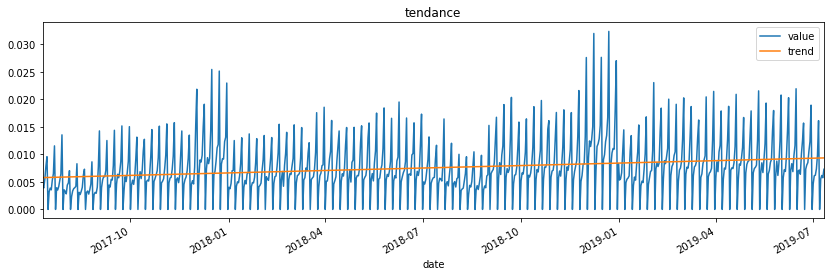

In [5]:
from statsmodels.tsa.tsatools import detrend
notrend = detrend(df.value, order=1)
df["notrend"] = notrend
df["trend"] = df['value'] - notrend
ax = df.plot(x="date", y=["value", "trend"], figsize=(14,4))
ax.set_title('tendance');

Autocorrélations...

In [6]:
from statsmodels.tsa.stattools import acf
cor = acf(df.value)
cor

array([ 1.        ,  0.00362009, -0.06381142, -0.01921664, -0.02160291,
       -0.07135052, -0.00899597,  0.94005908, -0.0130833 , -0.08036241,
       -0.03826841, -0.0415807 , -0.09018422, -0.02688233,  0.89988088,
       -0.03005134, -0.10295382, -0.06045724, -0.06013168, -0.10755724,
       -0.04148442,  0.86440539, -0.04999528, -0.12277966, -0.0791179 ,
       -0.0833784 , -0.12928969, -0.06203225,  0.82714141, -0.06742072,
       -0.13976608, -0.10027103, -0.10142947, -0.14079539, -0.07328448,
        0.80526625, -0.0714792 , -0.13771261, -0.09688041, -0.09731681,
       -0.14170474])

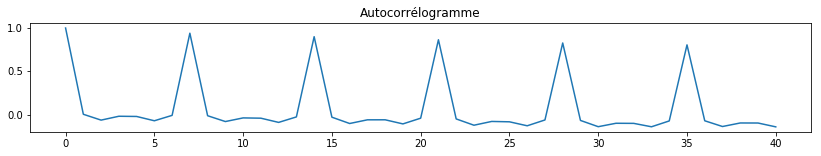

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(14,2))
ax.plot(cor)
ax.set_title("Autocorrélogramme");

La première saisonalité apparaît, 7, 14, 21... Les autocorrélations partielles confirment cela, plutôt 7 jours.

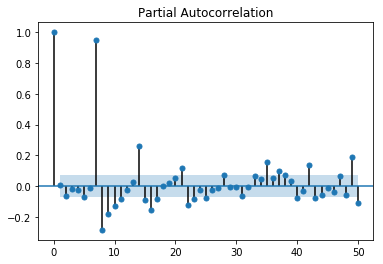

In [8]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df.value, lags=50);

Comme il n'y a rien le dimanche, il vaut mieux les enlever. Garder des zéros nous priverait de modèles multiplicatifs.

In [9]:
df["weekday"] = df.date.dt.weekday
df.head()

,date,value,notrend,trend,weekday
0,2017-07-11 00:42:57.463554,0.004343,-0.001443,0.005786,1
1,2017-07-12 00:42:57.463554,0.003907,-0.001884,0.005791,2
2,2017-07-13 00:42:57.463554,0.005510,-0.000286,0.005796,3
3,2017-07-14 00:42:57.463554,0.007843,0.002042,0.005801,4
4,2017-07-15 00:42:57.463554,0.009586,0.003780,0.005806,5


In [10]:
df_nosunday = df[df.weekday != 6]
df_nosunday.head(n=10)

,date,value,notrend,trend,weekday
0,2017-07-11 00:42:57.463554,0.004343,-0.001443,0.005786,1
1,2017-07-12 00:42:57.463554,0.003907,-0.001884,0.005791,2
2,2017-07-13 00:42:57.463554,0.005510,-0.000286,0.005796,3
3,2017-07-14 00:42:57.463554,0.007843,0.002042,0.005801,4
4,2017-07-15 00:42:57.463554,0.009586,0.003780,0.005806,5
6,2017-07-17 00:42:57.463554,0.003208,-0.002608,0.005816,0
7,2017-07-18 00:42:57.463554,0.003874,-0.001947,0.005821,1
8,2017-07-19 00:42:57.463554,0.003565,-0.002260,0.005825,2
9,2017-07-20 00:42:57.463554,0.005354,-0.000476,0.005830,3
10,2017-07-21 00:42:57.463554,0.006507,0.000671,0.005835,4


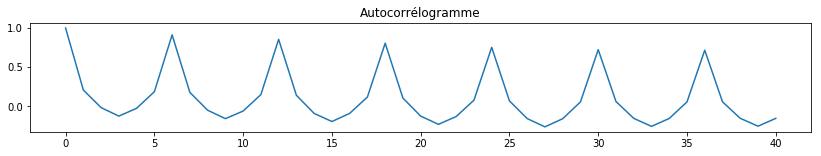

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(14,2))
cor = acf(df_nosunday.value)
ax.plot(cor)
ax.set_title("Autocorrélogramme");

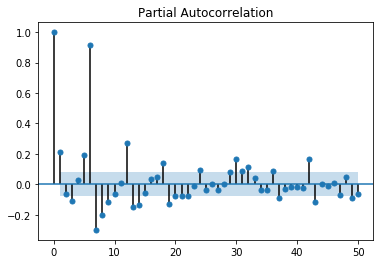

In [12]:
plot_pacf(df_nosunday.value, lags=50);

On décompose la série en tendance + saisonnalité. Les étés et Noël apparaissent.

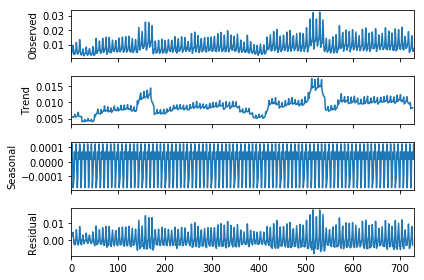

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(df_nosunday.value, freq=7)
res.plot();

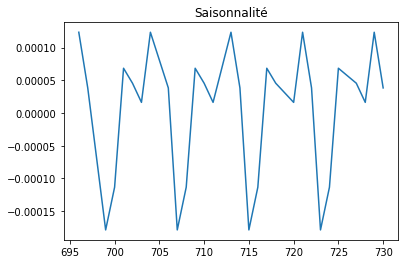

In [14]:
plt.plot(res.seasonal[-30:])
plt.title("Saisonnalité");

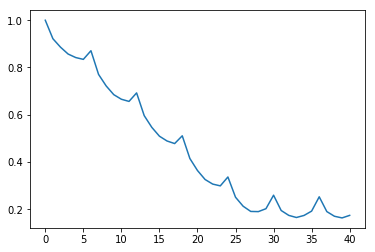

In [15]:
cor = acf(res.trend[5:-5]);
plt.plot(cor);

On cherche maintenant la saisonnalité de la série débarrassée de sa tendance herbdomadaire. On retrouve la saisonnalité mensuelle.

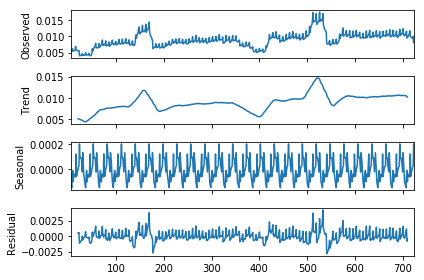

In [16]:
res_year = seasonal_decompose(res.trend[5:-5], freq=25)
res_year.plot();

## Test de stationnarité

Le test [KPSS](https://en.wikipedia.org/wiki/KPSS_test) permet de tester la stationnarité d'une série.

In [17]:
from statsmodels.tsa.stattools import kpss
kpss(res.trend[5:-5])

c:\python372_x64\lib\site-packages\statsmodels\tsa\stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


(1.2355012644507275,
 0.01,
 19,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Comme ce n'est pas toujours facile à interpréter, on simule une variable aléatoire gaussienne donc sans tendance.

In [18]:
from numpy.random import randn
bruit = randn(1000)
kpss(bruit)

c:\python372_x64\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


(0.08040698003110743,
 0.1,
 22,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Et puis une série avec une tendance forte.

In [19]:
from numpy.random import randn
from numpy import arange
bruit = randn(1000) * 100 + arange(1000) / 10
kpss(bruit)

(3.0258314859067346,
 0.01,
 22,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Une valeur forte indique une tendance et la série en a clairement une.

## Prédiction

Les modèles *AR*, *ARMA*, *ARIMA* se concentrent sur une série à une dimension. En machine learning, il y a la série et plein d'autres informations. On construit une matrice avec des séries décalées.

In [20]:
from statsmodels.tsa.tsatools import lagmat
lag = 8
X = lagmat(df_nosunday["value"], lag)
lagged = df_nosunday.copy()
for c in range(1,lag+1):
    lagged["lag%d" % c] = X[:, c-1]
lagged.tail()

,date,value,notrend,trend,weekday,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8
725,2019-07-06 00:42:57.463554,0.016143,0.006803,0.009340,5,0.009874,0.007377,0.006215,0.006125,0.004659,0.018962,0.012340,0.010584
727,2019-07-08 00:42:57.463554,0.005521,-0.003828,0.009350,0,0.016143,0.009874,0.007377,0.006215,0.006125,0.004659,0.018962,0.012340
728,2019-07-09 00:42:57.463554,0.006169,-0.003185,0.009355,1,0.005521,0.016143,0.009874,0.007377,0.006215,0.006125,0.004659,0.018962
729,2019-07-10 00:42:57.463554,0.005761,-0.003598,0.009360,2,0.006169,0.005521,0.016143,0.009874,0.007377,0.006215,0.006125,0.004659
730,2019-07-11 00:42:57.463554,0.007298,-0.002066,0.009364,3,0.005761,0.006169,0.005521,0.016143,0.009874,0.007377,0.006215,0.006125


On ajoute ou on réécrit le jour de la semaine qu'on utilise comme variable supplémentaire.

In [21]:
lagged["weekday"] = lagged.date.dt.weekday

In [22]:
X = lagged.drop(["date", "value", "notrend", "trend"], axis=1)
Y = lagged["value"]
X.shape, Y.shape

((627, 9), (627,))

In [23]:
from numpy import corrcoef
corrcoef(X)

array([[1.        , 0.99999768, 0.9999984 , ..., 0.99988562, 0.99998624,
        0.99999426],
       [0.99999768, 1.        , 0.99999842, ..., 0.99987383, 0.99998196,
        0.99999019],
       [0.9999984 , 0.99999842, 1.        , ..., 0.99988949, 0.99998163,
        0.99999067],
       ...,
       [0.99988562, 0.99987383, 0.99988949, ..., 1.        , 0.99985769,
        0.9998667 ],
       [0.99998624, 0.99998196, 0.99998163, ..., 0.99985769, 1.        ,
        0.99998297],
       [0.99999426, 0.99999019, 0.99999067, ..., 0.9998667 , 0.99998297,
        1.        ]])

Etrange autant de grandes valeurs, cela veut dire que la tendance est trop forte pour calculer des corrélations, il vaudrait mieux tout recommencer avec la série $\Delta Y_t = Y_t - Y_{t-1}$. Bref, passons...

In [24]:
X.columns

Index(['weekday', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7',
       'lag8'],
      dtype='object')

Une régression linéaire car les modèles linéaires sont toujours de bonnes baseline et pour connaître le modèle simulé, on ne fera pas beaucoup mieux.

In [25]:
from sklearn.linear_model import LinearRegression
clr = LinearRegression()
clr.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
from sklearn.metrics import r2_score
r2_score(Y, clr.predict(X))

0.8871731691386393

In [27]:
clr.coef_

array([ 0.0013905 ,  0.30199857,  0.23427587,  0.06485249,  0.00318444,
       -0.05888168,  0.52878846, -0.116649  , -0.08068854])

On retrouve la saisonnalité, $Y_t$ et $Y_{t-6}$ sont de mèches.

In [28]:
for i in range(1, X.shape[1]):
    print("X(t-%d)" % (i), r2_score(Y, X.iloc[:, i]))

X(t-1) -0.5799344874123231
X(t-2) -1.0271995693021703
X(t-3) -1.2451181610331497
X(t-4) -1.0497781280554928
X(t-5) -0.6300696727754616
X(t-6) 0.8212380818165589
X(t-7) -0.643903114304551
X(t-8) -1.09689904382877


Auparavant (l'année dernière en fait), je construisais deux bases, apprentissage et tests, comme ceci :

In [29]:
n = X.shape[0]
X_train = X.iloc[:n * 2//3]
X_test = X.iloc[n * 2//3:]
Y_train = Y[:n * 2//3]
Y_test = Y[n * 2//3:]

Et puis *scikit-learn* est arrivée avec [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

In [30]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(lagged):
    data_train, data_test = lagged.iloc[train_index, :], lagged.iloc[test_index, :]
    print("TRAIN:", data_train.shape, "TEST:", data_test.shape)

TRAIN: (107, 13) TEST: (104, 13)
TRAIN: (211, 13) TEST: (104, 13)
TRAIN: (315, 13) TEST: (104, 13)
TRAIN: (419, 13) TEST: (104, 13)
TRAIN: (523, 13) TEST: (104, 13)


Et on calé une forêt aléatoire...

In [31]:
import warnings
from sklearn.ensemble import RandomForestRegressor
clr = RandomForestRegressor()

def train_test(clr, train_index, test_index):
    data_train = lagged.iloc[train_index, :]
    data_test = lagged.iloc[test_index, :]
    clr.fit(data_train.drop(["value", "date", "notrend", "trend"], 
                            axis=1), 
            data_train.value)
    r2 = r2_score(data_test.value,
                  clr.predict(data_test.drop(["value", "date", "notrend",
                                              "trend"], axis=1).values))
    return r2

warnings.simplefilter("ignore")
last_test_index = None
for train_index, test_index in tscv.split(lagged):
    r2 = train_test(clr, train_index, test_index)        
    if last_test_index is not None:
        r2_prime = train_test(clr, last_test_index, test_index)        
        print(r2, r2_prime)
    else:
        print(r2)
    last_test_index = test_index

0.6795844303954097
0.8643514472109561 0.8438674497139955
0.889424015517347 0.8566080912412136
0.8108804128996021 0.652299214153693
0.9082580468326908 0.9146950904017541


2 ans coupé en 5, soit tous les 5 mois, ça veut dire que ce découpage inclut parfois Noël, parfois l'été et que les performances y seront très sensibles.

In [32]:
from sklearn.metrics import r2_score
r2 = r2_score(data_test.value,
              clr.predict(data_test.drop(["value", "date", "notrend",
                                          "trend"], axis=1).values))
r2

0.9146950904017541

On compare avec le $r_2$ avec le même $r_2$ obtenu en utilisant $Y_{t-1}$, $Y_{t-2}$, ... $Y_{t-d}$ comme prédiction.

In [33]:
for i in range(1, 9):
    print(i, ":", r2_score(data_test.value, data_test["lag%d" % i]))

1 : -0.9357733133623056
2 : -1.4886358005577112
3 : -1.8674091365311156
4 : -1.5617646397661757
5 : -0.9531085434874935
6 : 0.8567402931376816
7 : -0.9271996269480662
8 : -1.5219232924913277


In [34]:
lagged[:5]

,date,value,notrend,trend,weekday,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8
0,2017-07-11 00:42:57.463554,0.004343,-0.001443,0.005786,1,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,2017-07-12 00:42:57.463554,0.003907,-0.001884,0.005791,2,0.004343,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,2017-07-13 00:42:57.463554,0.005510,-0.000286,0.005796,3,0.003907,0.004343,0.000000,0.000000,0.0,0.0,0.0,0.0
3,2017-07-14 00:42:57.463554,0.007843,0.002042,0.005801,4,0.005510,0.003907,0.004343,0.000000,0.0,0.0,0.0,0.0
4,2017-07-15 00:42:57.463554,0.009586,0.003780,0.005806,5,0.007843,0.005510,0.003907,0.004343,0.0,0.0,0.0,0.0


En fait le jour de la semaine est une variable catégorielle, on crée une colonne par jour.

In [35]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [36]:
cols = ['lag1', 'lag2', 'lag3',
        'lag4', 'lag5', 'lag6', 'lag7', 'lag8']
ct = ColumnTransformer(
        [('pass', "passthrough", cols),
         ("dummies", OneHotEncoder(), ["weekday"])])
pred = ct.fit(lagged).transform(lagged[:5])
pred

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.004343  , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        ],
       [0.00390703, 0.004343  , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        ],
       [0.0055104 , 0.00390703, 0.004343  , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        ],
       [0.00784338, 0.0055104 , 0.00390703, 0.004343  , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        ]])

On met tout dans un pipeline parce que c'est plus joli, plus pratique aussi.

In [37]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA, TruncatedSVD 
cols = ['lag1', 'lag2', 'lag3',
        'lag4', 'lag5', 'lag6', 'lag7', 'lag8']
model = make_pipeline(
         make_pipeline(
                 ColumnTransformer(
                    [('pass', "passthrough", cols),
                     ("dummies", make_pipeline(OneHotEncoder(), 
                                               TruncatedSVD(n_components=2)), ["weekday"])]),
        LinearRegression()))
model.fit(lagged, lagged["value"])

Pipeline(memory=None,
         steps=[('pipeline',
                 Pipeline(memory=None,
                          steps=[('columntransformer',
                                  ColumnTransformer(n_jobs=None,
                                                    remainder='drop',
                                                    sparse_threshold=0.3,
                                                    transformer_weights=None,
                                                    transformers=[('pass',
                                                                   'passthrough',
                                                                   ['lag1',
                                                                    'lag2',
                                                                    'lag3',
                                                                    'lag4',
                                                                    'lag5',
                               

C'est plus facile à voir visuellement.

In [38]:
from mlinsights.plotting import pipeline2dot
dot = pipeline2dot(model, lagged)
from jyquickhelper import RenderJsDot
RenderJsDot(dot)

In [39]:
r2_score(lagged['value'], model.predict(lagged))

0.8574424275365004

## Templating

Complètement hors sujet mais utile.

In [40]:
from jinja2 import Template
template = Template('Hello {{ name }}!')
template.render(name='John Doe')

'Hello John Doe!'

In [41]:
template = Template("""
{{ name }}
{{ "-" * len(name) }}
Possède :
{% for i in range(len(meubles)) %}
- {{meubles[i]}}{% endfor %}
""")
meubles = ['table', "tabouret"]
print(template.render(name='John Doe Doe', len=len,
                     meubles=meubles))


John Doe Doe
------------
Possède :

- table
- tabouret
